In [28]:
import pandas as pd
from pandas import Series, DataFrame
from patsy import dmatrices
import warnings
%pylab inline
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from StringIO import StringIO
from sklearn.model_selection import cross_val_score, StratifiedKFold

Populating the interactive namespace from numpy and matplotlib


In [32]:
df = pd.read_csv('aac_shelter_outcomes.csv')
df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [35]:
df.drop_duplicates(['animal_id'], keep='last', inplace=True)

In [36]:
df.drop(labels=['animal_id', 'monthyear'], axis=1, inplace=True)
df.head()

,age_upon_outcome,animal_type,breed,color,date_of_birth,datetime,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [37]:
len(df)

70855

Dog          38067
Cat          28210
Other         4235
Bird           334
Livestock        9
Name: animal_type, dtype: int64

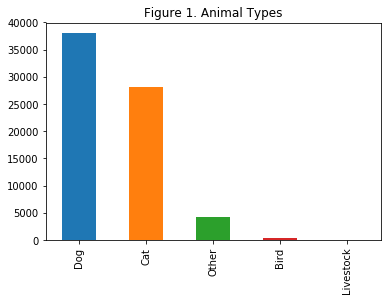

In [40]:
df['animal_type'].value_counts().plot(kind='bar', title='Figure 1. Animal Types')
df['animal_type'].value_counts()

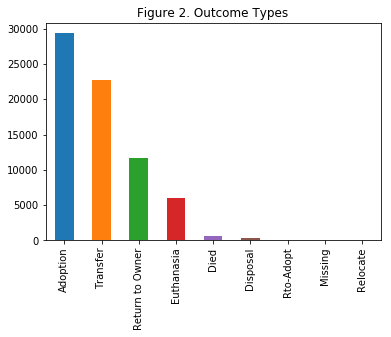

In [42]:
df['outcome_type'].value_counts().plot(kind='bar', title='Figure 2. Outcome Types')

In [52]:
df = df[df['date_of_birth'] < df['datetime']]

In [55]:
df[df['animal_type'] == "Dog"]["breed"].value_counts().head()

Pit Bull Mix                 4919
Chihuahua Shorthair Mix      4326
Labrador Retriever Mix       3994
German Shepherd Mix          1617
Australian Cattle Dog Mix     922
Name: breed, dtype: int64

In [56]:
df[df['animal_type'] == 'Cat']['breed'].value_counts().head()

Domestic Shorthair Mix      22390
Domestic Medium Hair Mix     2227
Domestic Longhair Mix        1172
Siamese Mix                   948
Domestic Shorthair            370
Name: breed, dtype: int64

In [57]:
df[df['animal_type'] == "Other"]['breed'].value_counts().head()

Bat Mix          1284
Bat               798
Raccoon Mix       465
Rabbit Sh Mix     288
Raccoon           230
Name: breed, dtype: int64

In [58]:
def classify_breed(breed):
    ''' classifies mixes where the mix is specified with a slash to fall under the first listed breed as a mix'''
    breed_list = breed.split("/")
    if len(breed_list) > 1:
        return breed_list[0] + " Mix"
    return breed_list[0]

In [59]:
mask = df['name'].isnull()
df['has_name'] = 1
df['has_name'][mask] = 0
mask = df['outcome_type'] == 'Adoption'
df['adopted'] = 0
df['adopted'][mask] = 1
df['date_of_birth'] = pd.to_datetime(df['date_of_birth'], format='%Y-%m-%d')
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d')
df['days_alive'] = df['datetime'].sub(df['date_of_birth'], axis = 0)
df['days_alive'] = df['days_alive'].dt.days
df['age_binned'] = pd.qcut(df['days_alive'], 5)
df['breed_reclassed'] = df['breed'].map(classify_breed)
df

,age_upon_outcome,animal_type,breed,color,date_of_birth,datetime,name,outcome_subtype,outcome_type,sex_upon_outcome,has_name,adopted,days_alive,age_binned,breed_reclassed
0,2 weeks,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,NaN,Partner,Transfer,Intact Male,0,0,15,"(-0.001, 75.0]",Domestic Shorthair Mix
1,1 year,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,Lucy,Partner,Transfer,Spayed Female,1,0,366,"(248.0, 554.0]",Beagle Mix
2,1 year,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,*Johnny,NaN,Adoption,Neutered Male,1,1,429,"(248.0, 554.0]",Pit Bull
3,9 years,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15 15:50:00,Monday,Partner,Transfer,Neutered Male,1,0,3300,"(1139.0, 9137.0]",Miniature Schnauzer Mix
4,5 months,Other,Bat Mix,Brown,2014-01-07,2014-07-07 14:04:00,NaN,Rabies Risk,Euthanasia,Unknown,0,0,181,"(75.0, 248.0]",Bat Mix
5,4 months,Dog,Leonberger Mix,Brown/White,2013-06-03,2013-10-07 13:06:00,*Edgar,Partner,Transfer,Intact Male,1,0,126,"(75.0, 248.0]",Leonberger Mix
6,1 year,Other,Squirrel Mix,Tan,2013-12-13,2014-12-13 12:20:00,NaN,Suffering,Euthanasia,Unknown,0,0,365,"(248.0, 554.0]",Squirrel Mix
7,3 years,Dog,Chihuahua Shorthair Mix,Brown,2011-11-23,2014-12-08 15:55:00,*Ella,Partner,Transfer,Spayed Female,1,0,1111,"(554.0, 1139.0]",Chihuahua Shorthair Mix
8,1 month,Cat,Domestic Shorthair Mix,Blue Tabby/White,2014-06-16,2014-08-14 18:45:00,Lucy,NaN,Adoption,Intact Female,1,1,59,"(-0.001, 75.0]",Domestic Shorthair Mix
9,3 months,Cat,Domestic Shorthair Mix,White/Black,2014-03-26,2014-06-29 17:45:00,*Frida,Offsite,Adoption,Spayed Female,1,1,95,"(75.0, 248.0]",Domestic Shorthair Mix


In [60]:
df['breed_reclassed'].nunique()

552

In [61]:
df[df['outcome_type'] == 'Died']['age_binned'].value_counts()

(-0.001, 75.0]      343
(75.0, 248.0]        89
(248.0, 554.0]       88
(1139.0, 9137.0]     78
(554.0, 1139.0]      75
Name: age_binned, dtype: int64

In [62]:
df[df['outcome_type'] == 'Died']['animal_type'].value_counts()

Cat      400
Dog      135
Other    134
Bird       4
Name: animal_type, dtype: int64

In [63]:
def get_month(date):
    return date.month

In [64]:
df['month'] = df['datetime'].map(get_month)
df

,age_upon_outcome,animal_type,breed,color,date_of_birth,datetime,name,outcome_subtype,outcome_type,sex_upon_outcome,has_name,adopted,days_alive,age_binned,breed_reclassed,month
0,2 weeks,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,NaN,Partner,Transfer,Intact Male,0,0,15,"(-0.001, 75.0]",Domestic Shorthair Mix,7
1,1 year,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,Lucy,Partner,Transfer,Spayed Female,1,0,366,"(248.0, 554.0]",Beagle Mix,11
2,1 year,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,*Johnny,NaN,Adoption,Neutered Male,1,1,429,"(248.0, 554.0]",Pit Bull,6
3,9 years,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15 15:50:00,Monday,Partner,Transfer,Neutered Male,1,0,3300,"(1139.0, 9137.0]",Miniature Schnauzer Mix,6
4,5 months,Other,Bat Mix,Brown,2014-01-07,2014-07-07 14:04:00,NaN,Rabies Risk,Euthanasia,Unknown,0,0,181,"(75.0, 248.0]",Bat Mix,7
5,4 months,Dog,Leonberger Mix,Brown/White,2013-06-03,2013-10-07 13:06:00,*Edgar,Partner,Transfer,Intact Male,1,0,126,"(75.0, 248.0]",Leonberger Mix,10
6,1 year,Other,Squirrel Mix,Tan,2013-12-13,2014-12-13 12:20:00,NaN,Suffering,Euthanasia,Unknown,0,0,365,"(248.0, 554.0]",Squirrel Mix,12
7,3 years,Dog,Chihuahua Shorthair Mix,Brown,2011-11-23,2014-12-08 15:55:00,*Ella,Partner,Transfer,Spayed Female,1,0,1111,"(554.0, 1139.0]",Chihuahua Shorthair Mix,12
8,1 month,Cat,Domestic Shorthair Mix,Blue Tabby/White,2014-06-16,2014-08-14 18:45:00,Lucy,NaN,Adoption,Intact Female,1,1,59,"(-0.001, 75.0]",Domestic Shorthair Mix,8
9,3 months,Cat,Domestic Shorthair Mix,White/Black,2014-03-26,2014-06-29 17:45:00,*Frida,Offsite,Adoption,Spayed Female,1,1,95,"(75.0, 248.0]",Domestic Shorthair Mix,6


## Decision Tree - all animals

In [ ]:
Y, X = dmatrices('adopted ~ 0 + animal_type + has_name + color + age_binned + sex_upon_outcome + month', df, return_type='dataframe')
y = Y['adopted'].values
X.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [163]:
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 10)

In [164]:
result = model.fit(X_train, y_train)
prediction_train = model.predict(X_train)
print metrics.accuracy_score(y_train, prediction_train)

0.7763659930262702


In [165]:
prediction = model.predict(X_test)
print metrics.accuracy_score(y_test, prediction)

0.7683264471610513


## Decision Tree - Only Dogs and Cats

In [166]:
df_copy = df.copy()
mask = df_copy['animal_type'].isin(["Dog", "Cat"])
df_copy = df_copy[mask]
df_copy

,age_upon_outcome,animal_type,breed,color,date_of_birth,datetime,name,outcome_subtype,outcome_type,sex_upon_outcome,has_name,adopted,days_alive,age_binned,month,breed_reclassed
0,2 weeks,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,NaN,Partner,Transfer,Intact Male,0,0,15,"(-123.001, 78.0]",7,Domestic Shorthair Mix
1,1 year,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,Lucy,Partner,Transfer,Spayed Female,1,0,366,"(306.0, 669.0]",11,Beagle Mix
2,1 year,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,*Johnny,NaN,Adoption,Neutered Male,1,1,429,"(306.0, 669.0]",6,Pit Bull
3,9 years,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15 15:50:00,Monday,Partner,Transfer,Neutered Male,1,0,3300,"(1222.0, 9137.0]",6,Miniature Schnauzer Mix
5,4 months,Dog,Leonberger Mix,Brown/White,2013-06-03,2013-10-07 13:06:00,*Edgar,Partner,Transfer,Intact Male,1,0,126,"(78.0, 306.0]",10,Leonberger Mix
7,3 years,Dog,Chihuahua Shorthair Mix,Brown,2011-11-23,2014-12-08 15:55:00,*Ella,Partner,Transfer,Spayed Female,1,0,1111,"(669.0, 1222.0]",12,Chihuahua Shorthair Mix
8,1 month,Cat,Domestic Shorthair Mix,Blue Tabby/White,2014-06-16,2014-08-14 18:45:00,Lucy,NaN,Adoption,Intact Female,1,1,59,"(-123.001, 78.0]",8,Domestic Shorthair Mix
9,3 months,Cat,Domestic Shorthair Mix,White/Black,2014-03-26,2014-06-29 17:45:00,*Frida,Offsite,Adoption,Spayed Female,1,1,95,"(78.0, 306.0]",6,Domestic Shorthair Mix
10,1 year,Cat,Domestic Medium Hair Mix,Black/White,2013-03-27,2014-03-28 14:55:00,Stella Luna,NaN,Return to Owner,Spayed Female,1,0,366,"(306.0, 669.0]",3,Domestic Medium Hair Mix
11,2 years,Dog,Papillon/Border Collie,Black/White,2012-02-28,2014-03-28 14:39:00,Fancy,Partner,Transfer,Neutered Male,1,0,759,"(669.0, 1222.0]",3,Papillon Mix


In [167]:
Y, X = dmatrices('adopted ~ 0 + animal_type + has_name + color + sex_upon_outcome + breed_reclassed', df_copy, return_type='dataframe')
y = Y['adopted'].values
X.head()

,animal_type[Cat],animal_type[Dog],color[T.Agouti/Brown Tabby],color[T.Agouti/White],color[T.Apricot],color[T.Apricot/Brown],color[T.Apricot/Tricolor],color[T.Apricot/White],color[T.Black],color[T.Black Brindle],...,breed_reclassed[T.West Highland],breed_reclassed[T.West Highland Mix],breed_reclassed[T.Whippet],breed_reclassed[T.Whippet Mix],breed_reclassed[T.Wire Hair Fox Terrier],breed_reclassed[T.Wire Hair Fox Terrier Mix],breed_reclassed[T.Wirehaired Pointing Griffon Mix],breed_reclassed[T.Yorkshire Terrier],breed_reclassed[T.Yorkshire Terrier Mix],has_name
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
model = tree.DecisionTreeClassifier(criterion='entropy')

In [178]:
result = model.fit(X_train, y_train)
prediction_train = model.predict(X_train)
print metrics.accuracy_score(y_train, prediction_train)

0.7746252157554836


In [170]:
prediction = model.predict(X_test)
print metrics.accuracy_score(y_test, prediction)

0.701841712294674
